In [2]:
import os, sys
import json
import collections
import importlib
from typing import *

import numpy as np
import pandas as pd
from sklearn import metrics
import scipy.stats
from Levenshtein import distance as l_dist

from matplotlib import pyplot as plt

import anndata as ad
import scanpy as sc

import torch
import torch.nn as nn
import skorch
import skorch.helper

SRC_DIR = os.path.join(os.path.dirname(os.getcwd()), "tcr")
assert os.path.isdir(SRC_DIR), f"Cannot find src dir: {SRC_DIR}"
sys.path.append(SRC_DIR)
import custom_metrics
import data_loader as dl
import featurization as ft
import canonical_models as models
import mcmc
import entrez_utils
import model_utils
import plot_utils
import utils

LOCAL_DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), "data")
assert os.path.isdir(LOCAL_DATA_DIR)

DEVICE = utils.get_device(3)

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots/tcr_engineering_finetuned_mlm")
if not os.path.isdir(PLOT_DIR):
    os.makedirs(PLOT_DIR)
assert os.path.isdir(PLOT_DIR)

entrez_utils.setup_entrez_credentials()

In [3]:
importlib.reload(dl)
lcmv = dl.load_lcmv_table()
lcmv.head()

INFO:root:Loaded in table of 20351 entries
INFO:root:16768 entries remain after dropping na
INFO:root:15028 entries remain after dropping unsorted
INFO:root:20522 entries after expanding multiple entries
INFO:root:Class TetPos: 1819
INFO:root:Class TetNeg: 17477
INFO:root:Class TetMid: 1226


,tetramer,tcr_cdr3s_aa,tcr_cdr3s_nt,TRB,TRA,nCells,Prop,TRA_nt,TRB_nt,antigen.sequence,...,S.Score,G2M.Score,Phase,phenotype,v_a_gene,d_a_gene,j_a_gene,v_b_gene,d_b_gene,j_b_gene
0,TetPos,TRA:CAFEVVGQLTF;TRB:CASSFRDSSYEQYF,TRA:TGTGCTTTCGAGGTTGTGGGGCAGCTCACTTTC;TRB:TGTG...,CASSFRDSSYEQYF,CAFEVVGQLTF,3728,0.994664,TGTGCTTTCGAGGTTGTGGGGCAGCTCACTTTC,TGTGCCAGCAGTTTCAGGGACAGCTCCTATGAACAGTACTTC,KAVYNFATC,...,-0.010752,-0.050206,G1,TEx,TRAV16N,None,TRAJ5,TRBV14,None,TRBJ2-7
1,TetPos,TRA:CAVSAWVGDNSKLIW;TRB:CASSRDSLTEVFF,TRA:TGCGCAGTCAGTGCATGGGTTGGTGACAACAGTAAGCTGATT...,CASSRDSLTEVFF,CAVSAWVGDNSKLIW,1805,0.981512,TGCGCAGTCAGTGCATGGGTTGGTGACAACAGTAAGCTGATTTGG,TGTGCCAGCAGCCGGGACAGCTTGACAGAAGTCTTCTTT,KAVYNFATC,...,-0.100078,-0.016706,G1,TEx,TRAV3D-3,None,TRAJ38,TRBV3,None,TRBJ1-1
2,TetPos,TRA:CAQLEGADRLTF;TRB:CASSDHTNTEVFF,TRA:TGTGCTCAGTTAGAAGGTGCAGATAGACTCACCTTT;TRB:T...,CASSDHTNTEVFF,CAQLEGADRLTF,1299,0.999231,TGTGCTCAGTTAGAAGGTGCAGATAGACTCACCTTT,TGTGCCAGCAGTGATCACACAAACACAGAAGTCTTCTTT,KAVYNFATC,...,-0.112835,-0.128558,G1,TEx_progenitor,TRAV6-7-DV9,None,TRAJ45,TRBV13-3,None,TRBJ1-1
3,TetNeg,TRA:CAMSDLSNNAGAKLTF;TRB:CASSRDNNYAEQFF,TRA:TGTGCTATGAGTGATCTGAGTAATAATGCAGGTGCCAAGCTC...,CASSRDNNYAEQFF,CAMSDLSNNAGAKLTF,954,0.947368,TGTGCTATGAGTGATCTGAGTAATAATGCAGGTGCCAAGCTCACATTC,TGTGCTAGCAGCCGGGACAATAACTATGCTGAGCAGTTCTTC,KAVYNFATC,...,-0.075815,-0.128061,G1,TEx,TRAV6D-3,None,TRAJ39,TRBV17,None,TRBJ2-1
4,TetNeg,TRA:CALGLYGNEKITF;TRB:CASSVTSANTEVFF,TRA:TGTGCTCTGGGTCTCTATGGAAATGAGAAAATAACTTTT;TR...,CASSVTSANTEVFF,CALGLYGNEKITF,894,0.951064,TGTGCTCTGGGTCTCTATGGAAATGAGAAAATAACTTTT,TGTGCCAGCAGCGTGACAAGTGCAAACACAGAAGTCTTCTTT,KAVYNFATC,...,-0.129156,-0.089390,G1,TEx_transitory,TRAV6N-7,None,TRAJ48,TRBV10,None,TRBJ1-1


In [4]:
lcmv_dedup_tra_trb, lcmv_dedup_labels = dl.dedup_lcmv_table(lcmv)
lcmv_dedup_tra, lcmv_dedup_trb = zip(*lcmv_dedup_tra_trb)
lcmv_dedup = pd.DataFrame(
    {
        "TRA": lcmv_dedup_tra,
        "TRB": lcmv_dedup_trb,
        "tetramer": lcmv_dedup_labels,
        "label": ["TetPos" in l or "TetMid" in l for l in lcmv_dedup_labels],
    }
)
lcmv_dedup.head()

INFO:root:Deduped from 20522 -> 17772 merging 101 labels
INFO:root:Combined labels [('TetNeg', 15396), ('TetPos', 1216), ('TetMid', 1059), ('TetMid,TetNeg', 55), ('TetMid,TetPos', 31), ('TetNeg,TetPos', 14), ('TetMid,TetNeg,TetPos', 1)]
INFO:root:Filtering out labels ('TetMid,TetNeg', 'TetNeg,TetPos', 'TetMid,TetNeg,TetPos')
INFO:root:Retaining 17702 pairs with unambiguous labels
INFO:root:LCMV deduped labels: [('TetNeg', 15396), ('TetPos', 1216), ('TetMid', 1059), ('TetMid,TetPos', 31)]


,TRA,TRB,tetramer,label
0,CAAAAAGNYKYVF,CASSLLGGSYEQYF,TetNeg,False
1,CAAAASNTNKVVF,CASSLGLGANTGQLYF,TetNeg,False
2,CAAAASSGSWQLIF,CASGPREANERLFF,TetNeg,False
3,CAAADNYAQGLTF,CASGEGPDYTF,TetNeg,False
4,CAAADNYAQGLTF,CASRDWGDEQYF,TetNeg,False


In [5]:
importlib.reload(model_utils)
net = model_utils.load_two_part_bert_classifier(device=3)

Computing MD5: /home/wukevin/.cache/gdown/tcrbert/tcrbert_lcmv_finetuned_1.0.tar.gz


INFO:root:Model tarball at: /home/wukevin/.cache/gdown/tcrbert/tcrbert_lcmv_finetuned_1.0.tar.gz


MD5 matches: /home/wukevin/.cache/gdown/tcrbert/tcrbert_lcmv_finetuned_1.0.tar.gz


In [6]:
dl.LOCAL_DATA_DIR

'/home/wukevin/projects/tcr/tcr-bert/data'

In [48]:
# Take the positive sequences that are being tested, and introduce mutations
ref_df = pd.read_csv(os.path.join(
    os.path.join(dl.LOCAL_DATA_DIR, "lcmv_tcr_tetramer_affinity_test_vdj_trust4_revised.csv")
)).dropna(axis=0, how='all')
pos_ref_df = ref_df[ref_df['tetramer_class'] == "TetPos"]
pos_ref_df.shape

(5, 34)

In [44]:
importlib.reload(mcmc)
importlib.reload(custom_metrics)

pos_ref_sequences = list(zip(
    pos_ref_df['TRA_cdr3'],
    pos_ref_df['TRB_cdr3'],
))

per_iteration_pvalues, per_iteration_best_seqs = mcmc.generate_binding_sequences_skorch(
    net=net,
    seed_seqs=pos_ref_sequences,
    dset_obj=dl.TcrFineTuneDataset,
    dset_kwargs={"skorch_mode": True, "idx_encode": True},
    n_iter=15,
    min_prob=0.95,
    sample_ratio=1.0,
    method="mlm",
    seed=6489,
    neg_baseline=True,
    device=net.device.index,
)
per_iteration_pvalues.shape

INFO:root:Stopping generation, min predicted prob exceeds floor of 0.95


(16, 5)

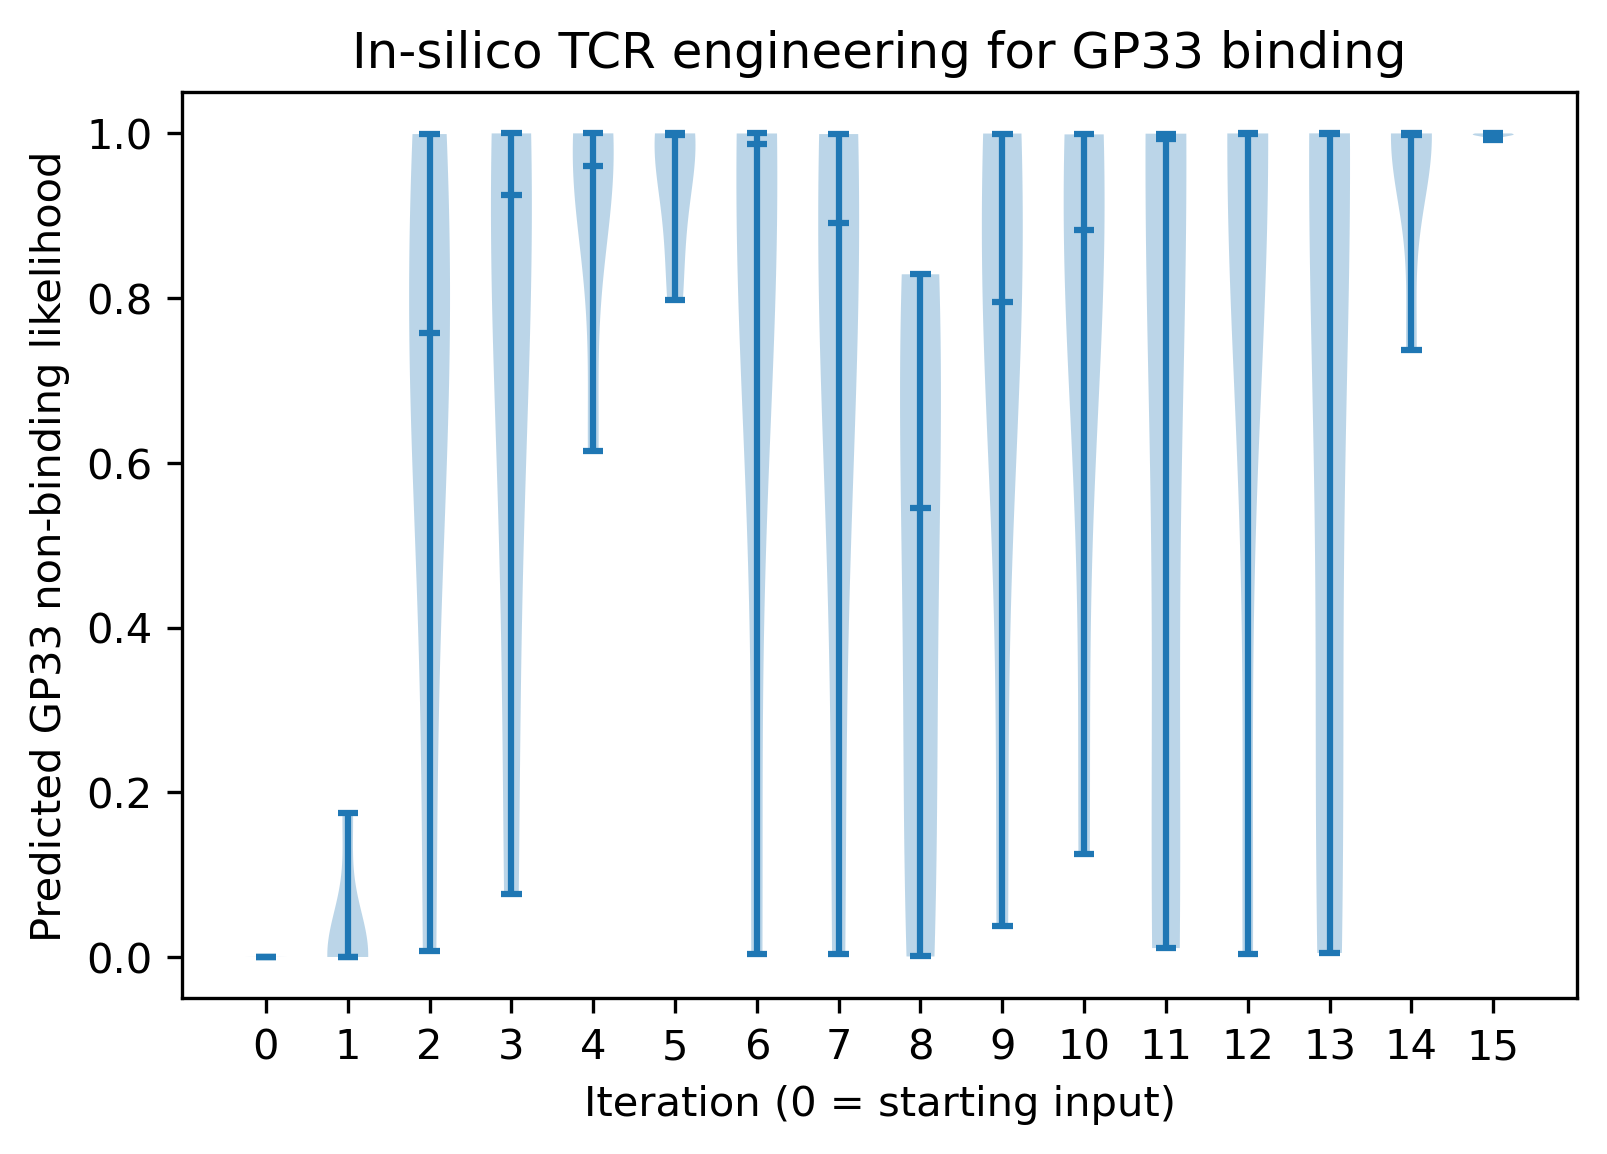

In [45]:
# Plot how the predicting GP33 binding changes over iterations

fig, ax = plt.subplots(dpi=300)
ax.violinplot(
    per_iteration_pvalues.T, positions=np.arange(len(per_iteration_pvalues)),
    showmedians=True, showextrema=True
)
ax.set(
    xlabel='Iteration (0 = starting input)',
    xticks=np.arange(len(per_iteration_pvalues)),
    ylabel=f"Predicted GP33 non-binding likelihood",
    title="In-silico TCR engineering for GP33 binding",
)
# fig.savefig(os.path.join(PLOT_DIR, "pred_gp33_affinity_iters.pdf"), bbox_inches='tight')
fig.show()

In [46]:
per_iteration_best_seqs[-1]

[('CAASSNTNKVVF', 'CASSEALWGHEQYF'),
 ('CATSSNTNKVVF', 'CASSLAGWGHEQYF'),
 ('CATDSNTNKVVF', 'CASSEADRGHEQYF'),
 ('CAASSNTNKVVF', 'CASSLAGWGYEQYF'),
 ('CAASSNTNKVVF', 'CASSLAGWGHEQYF')]

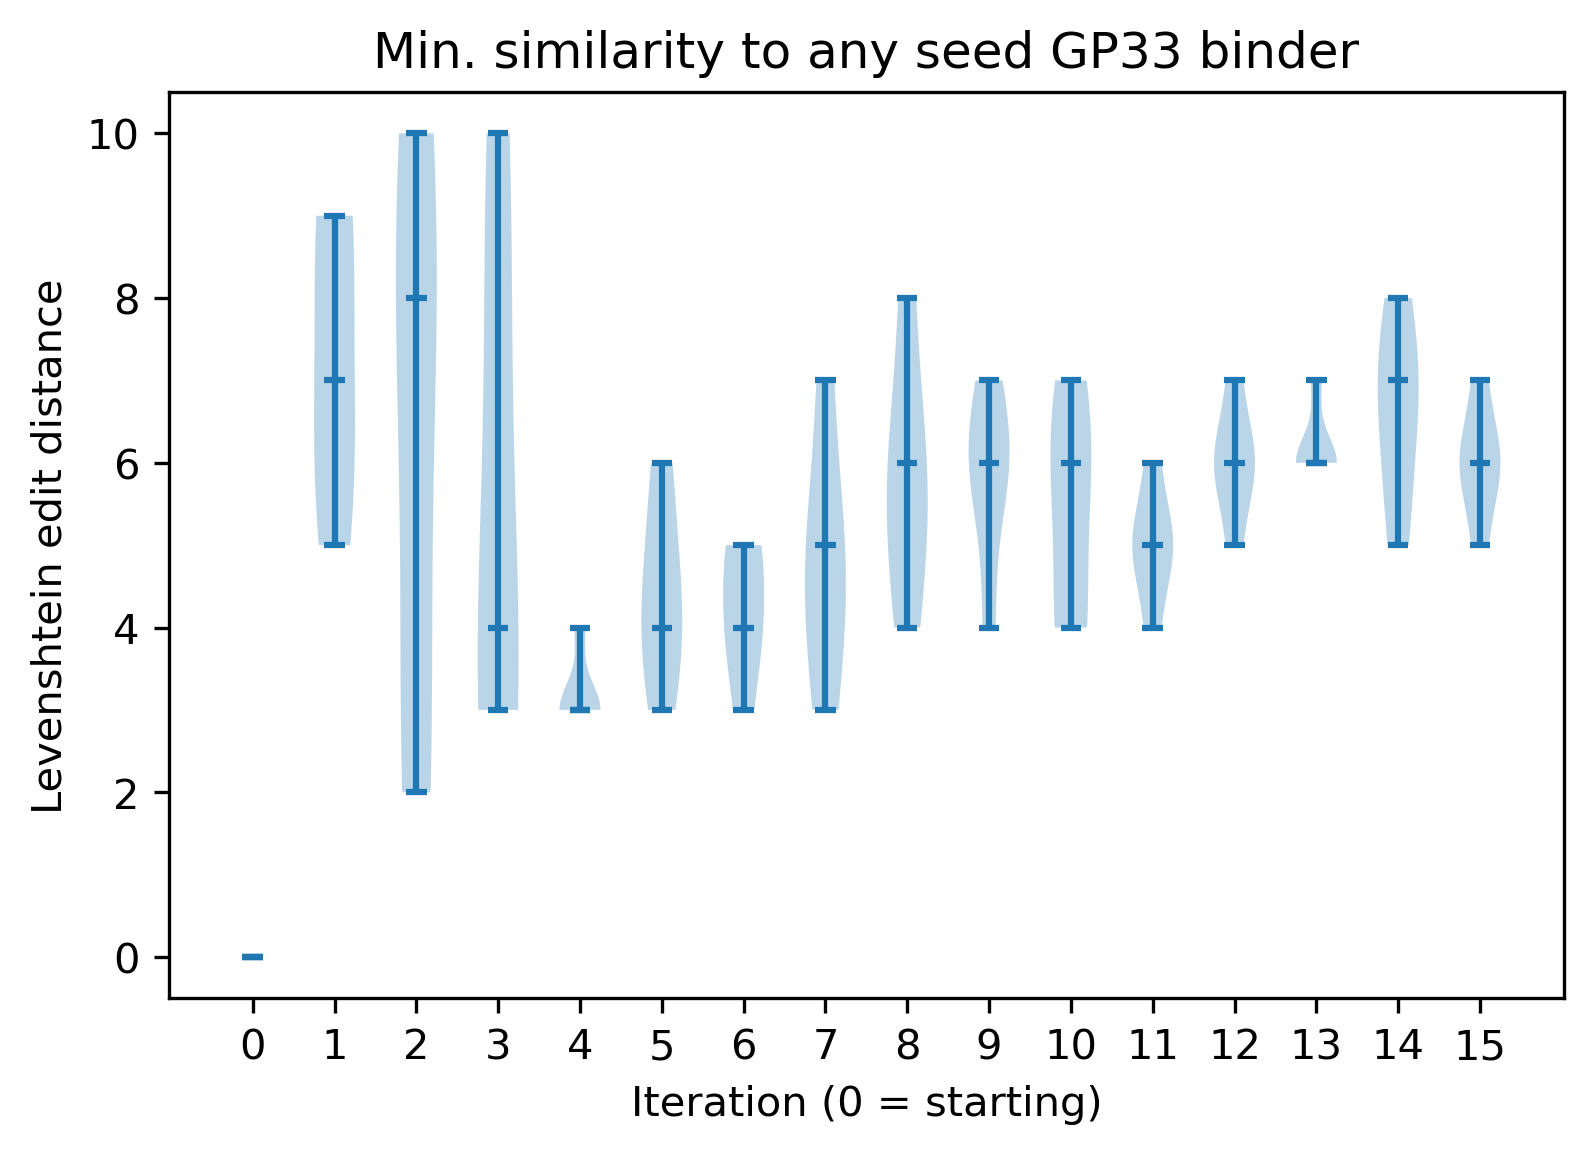

In [47]:
def tra_trb_dist(tra_trb_pair, ref_pairs=pos_ref_sequences) -> int:
    """Minimum Levenshtein distance between the given pair and any of ref pairs"""
    def pair_dist(p1:Tuple[str, str], p2:Tuple[str, str]) -> int:
        """Pair dist is the sum between the distance between the TRAs and the TRBs"""
        assert len(p1) == len(p2) == 2
        return l_dist(p1[0], p2[0]) + l_dist(p1[1], p2[1])
    dists = [pair_dist(tra_trb_pair, ref_pair) for ref_pair in ref_pairs]
    return np.min(dists)

per_iteration_edit_distances = [[tra_trb_dist(p) for p in seq_set] for seq_set in per_iteration_best_seqs]

fig, ax = plt.subplots(dpi=300)
ax.violinplot(
    per_iteration_edit_distances, positions=np.arange(len(per_iteration_pvalues)),
    showmedians=True, showextrema=True,
)
ax.set(
    xlabel='Iteration (0 = starting)',
    xticks=np.arange(len(per_iteration_pvalues)),
    ylabel="Levenshtein edit distance",
    title="Min. similarity to any seed GP33 binder",
)
# fig.savefig(os.path.join(PLOT_DIR, "similarity_known_binding_iters.pdf"), bbox_inches='tight')
fig.show()

In [49]:
with open("engineered_nonbinding_tcrs.json", 'w') as sink:
    json.dump(per_iteration_best_seqs, sink, indent=4)

In [50]:
eval_cutoff = 0.001
blastp_hits = entrez_utils.run_blast(
    [trb for tra, trb in per_iteration_best_seqs[-1]],
    db=entrez_utils.MOUSE_TRB_BLASTDB,
    e_val=eval_cutoff,
)
blastp_hits.head()

INFO:root:Running BLAST with E-value of 0.001 under: /tmp/tmpxhxustdz
INFO:root:Fetching addtl information for 25 matches


,query_acc,subject_acc,perc_identity,alignment_length,mismatches,gap_opens,query_start,query_end,subject_start,subject_end,evalue,bit_score,query_seq,subject_seq,ms_title
0,query-0,AFR46490,78.571,14,3,0,1,14,10,23,0.000231,26.9,CASSEALWGHEQYF,CASSDWDWGHEQYF,The LCMV gp33-specific memory T cell repertoir...
1,query-0,AFV60395,71.429,14,4,0,1,14,15,28,0.000244,27.7,CASSEALWGHEQYF,CASSRDRWGYEQYF,Conservation of Pathogenic TCR Homology across...
2,query-0,AAA51253,71.429,14,4,0,1,14,1,14,0.000491,26.2,CASSEALWGHEQYF,CASSQGDWGYEQYF,Junctional region sequences of T-cell receptor...
3,query-0,AFR46453,71.429,14,4,0,1,14,10,23,0.000763,25.8,CASSEALWGHEQYF,CASSQRTGGHEQYF,The LCMV gp33-specific memory T cell repertoir...
4,query-0,ACB13529,71.429,14,4,0,1,14,16,29,0.000768,26.2,CASSEALWGHEQYF,CASSSGLGGYEQYF,CD4+ T Cells Target Epitopes Residing within t...


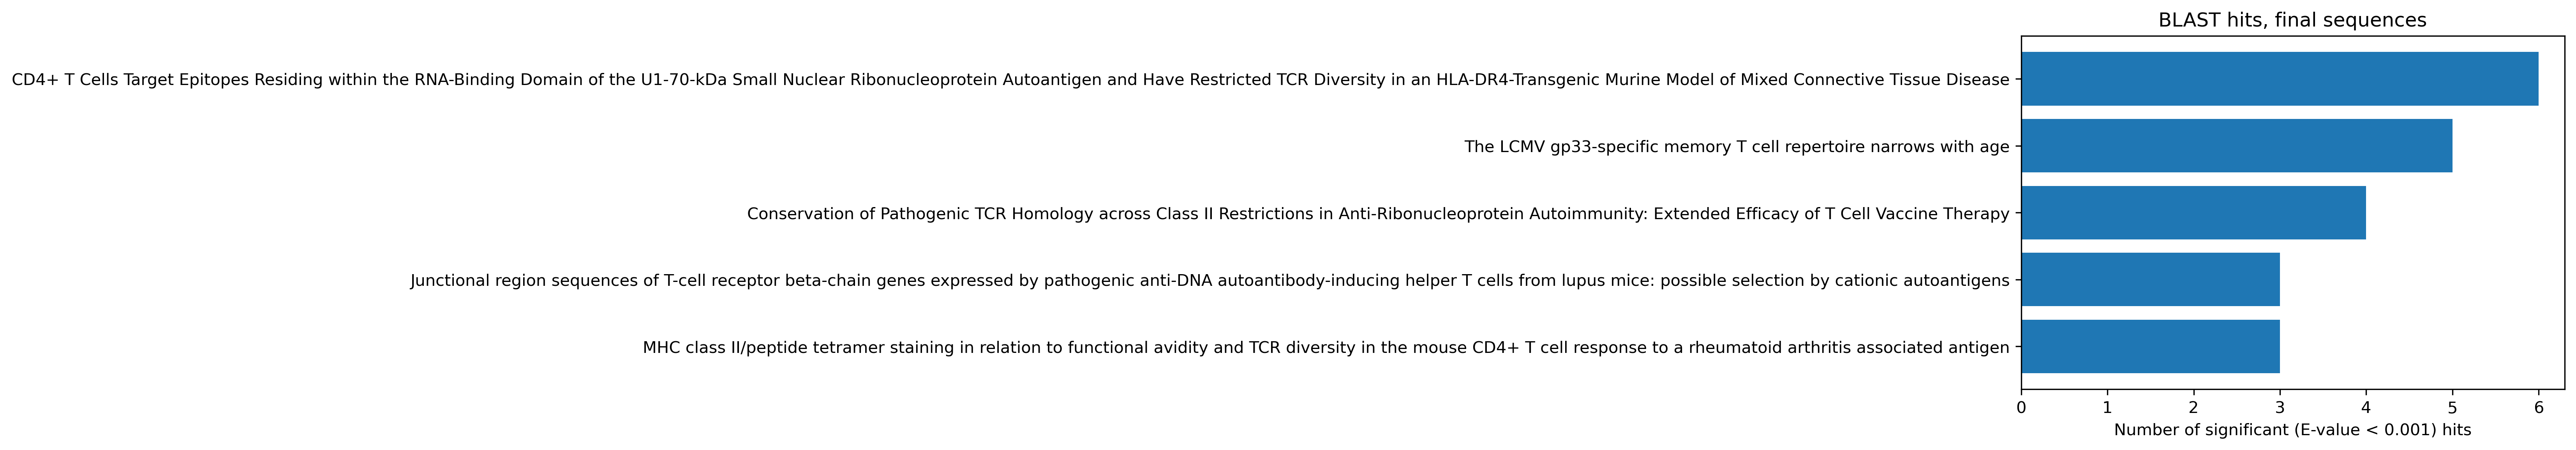

In [51]:
hit_titles_cnt = collections.Counter(blastp_hits['ms_title'])
fig, ax = plt.subplots(dpi=300)
ax.barh(np.arange(5), [v for _k, v in hit_titles_cnt.most_common(5)][::-1])
ax.set_yticks(np.arange(5))
ax.set_yticklabels(
    [k for k, _v in hit_titles_cnt.most_common(5)][::-1]
)
ax.set(
    xlabel=f"Number of significant (E-value < {eval_cutoff}) hits",
    title="BLAST hits, final sequences",
)
# fig.savefig(os.path.join(PLOT_DIR, "blast_hit_titles_final.pdf"), bbox_inches="tight")
fig.show()